# FPL Prediction: EDA

Notebook used to explore and visualise FPL data for the prediction of weekly player points

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.configs.data_config import IDENTIFIERS, REALS, CATEGORIES, TARGET

## Data Overview

Show information relating to data counts, columns and types...

In [2]:
fpl_data = pd.read_csv('./data/interim/raw.csv',index_col=0)
fpl_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34711 entries, 0 to 34710
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           34711 non-null  int64  
 1   element       34711 non-null  int64  
 2   season        34711 non-null  object 
 3   name          34711 non-null  object 
 4   fixture       34711 non-null  int64  
 5   GW            34711 non-null  int64  
 6   value         34711 non-null  int64  
 7   bps           34711 non-null  int64  
 8   influence     34711 non-null  float64
 9   creativity    34711 non-null  float64
 10  threat        34711 non-null  float64
 11  ict_index     34711 non-null  float64
 12  minutes       34711 non-null  int64  
 13  fdr_player    34711 non-null  int64  
 14  fdr_diff      34711 non-null  int64  
 15  position      34711 non-null  object 
 16  was_home      34711 non-null  bool   
 17  total_points  34711 non-null  int64  
dtypes: bool(1), float64(4), in

For the purposes of timeseries modelling, we can broadly seperate these features across several dimensions:

Time:
1. **TIME_VARYING**: Does the feature vary accoding to past or future timesteps
    or
2. **STATIC**: Is the feature constant across time

Data availability:
1. **KNOWN**: Do we have access to past and future information relating to the feature
    or
2. **UNKNOWN**: Only past information is known about the feature

Data Type
1. **REAL**: Continuous values that require scaling.
    or
2. **CATEGORICAL**: Requires label/one-hot encoding

We can classigify the FPL features as the following

In [3]:
from src.configs.data_config import TIME_VARYING_UNKNOWN_REALS,TIME_VARYING_UNKNOWN_CATEGORICALS, TIME_VARYING_KNOWN_REALS,STATIC_REALS,STATIC_CATEGORICALS,TIME_VARYING_KNOWN_CATEGORICALS,TARGET

print(f"TIME_VARYING_UNKNOWN_REALS:{TIME_VARYING_UNKNOWN_REALS}",f"TIME_VARYING_KNOWN_REALS:{TIME_VARYING_KNOWN_REALS}" ,\
    f"TIME_VARYING_UNKNOWN_CATEGORICALS:{TIME_VARYING_UNKNOWN_CATEGORICALS}",f"TIME_VARYING_KNOWN_CATEGORICALS:{TIME_VARYING_KNOWN_CATEGORICALS}",\
    f"STATIC_REALS:{STATIC_REALS}",f"STATIC_CATEGORICALS:{STATIC_CATEGORICALS}",\
    f"TARGET:{TARGET}",sep='\n')

TIME_VARYING_UNKNOWN_REALS:['bps', 'influence', 'creativity', 'threat', 'ict_index', 'minutes', 'total_points', 'value']
TIME_VARYING_KNOWN_REALS:['fdr_player', 'fdr_diff']
TIME_VARYING_UNKNOWN_CATEGORICALS:[]
TIME_VARYING_KNOWN_CATEGORICALS:['was_home']
STATIC_REALS:[]
STATIC_CATEGORICALS:['position']
TARGET:['total_points']


Here is the dirstibution of our target variable (y) total points:

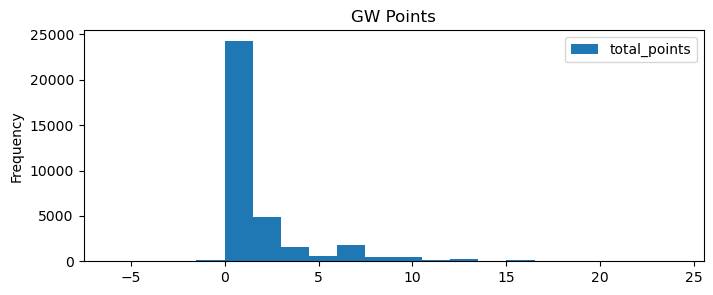

In [4]:
fpl_data[TARGET].plot.hist(bins=20,figsize=(8,3),title="GW Points")
plt.show()

Here is a bit of backgroind on the continuous input features (X):

In [5]:
fpl_data.loc[:,REALS].describe()

,value,bps,influence,creativity,threat,ict_index,minutes,fdr_player,fdr_diff
count,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000,34711.000000
mean,51.758088,6.374752,7.929532,5.148578,5.849903,1.891732,34.680649,2.949468,0.019994
std,12.378597,9.908128,13.351631,11.151231,14.157640,3.156143,41.136868,0.901220,1.301929
min,38.000000,-14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-3.000000
25%,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-1.000000
50%,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
75%,55.000000,11.000000,12.400000,3.400000,4.000000,2.800000,90.000000,4.000000,1.000000
max,136.000000,92.000000,131.000000,134.800000,152.000000,26.800000,90.000000,5.000000,3.000000


And here is an example of the type of the data for a single player for in a single season.

We would like to predict the total points (top plot) for all remaining games of the season using relevant input features:

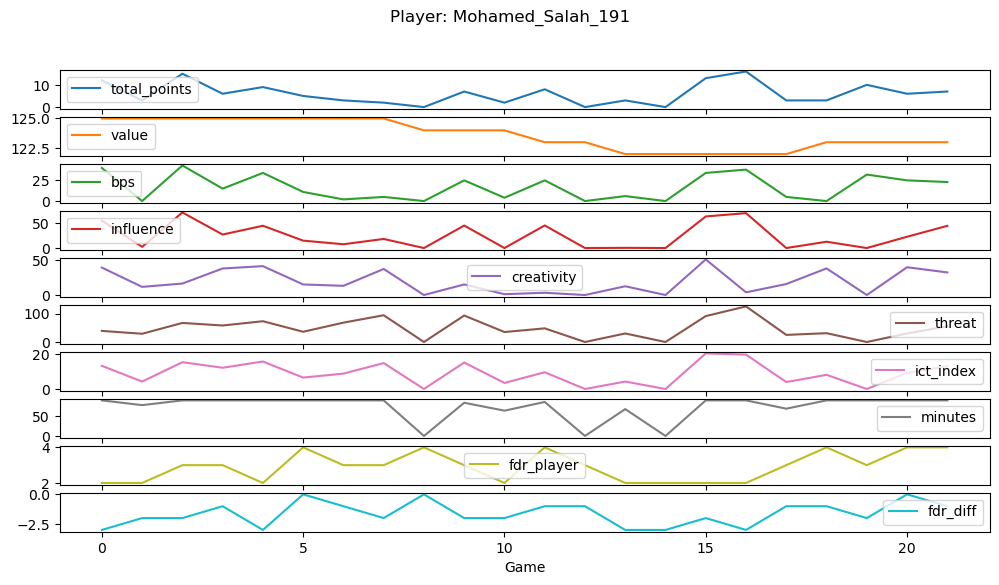

In [11]:
from src.plotting.eda import plot_example
plot_example(fpl_data,TARGET,REALS,uid=191201920)

We are only really interested in players that could be considered candidates for inclusion in a fantasy football team.

There are however many players in the raw data who play little or at all i.e. youth and reserve players.

The below plots show the total points of the season.


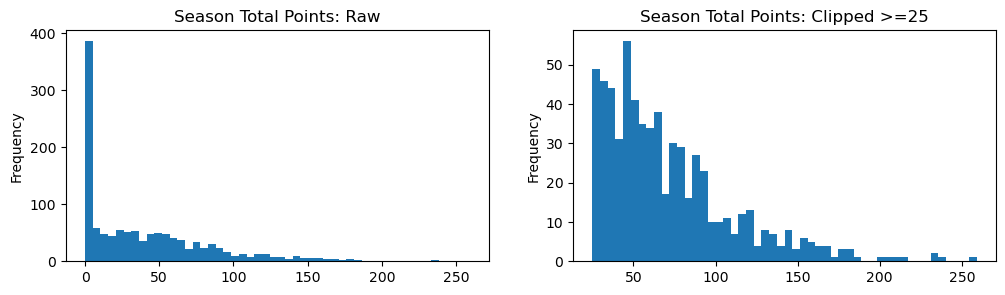

In [12]:
fig,axs = plt.subplots(1, 2,figsize = (12,3))
fpl_data.groupby('uid').sum().total_points.plot.hist(bins=50,ax=axs[0],title='Season Total Points: Raw')
fpl_data.groupby('uid').sum().total_points[lambda x:x>=25].plot.hist(bins=50,ax=axs[1],title='Season Total Points: Clipped >=25')
plt.show()

We can remove these players from the population using the below filter for the remaining analysis

In [13]:
points_ge25 = fpl_data.groupby('uid')['total_points'].transform(lambda x:x.sum()>=25)

## Correlations

We can review the correlation coefficients to quickly get a feel for the relevance of the continuous features.

In [14]:
# Function to extact grouped cross correlations
from src.data.feature_processing import crosscorr

The below plot shows the correlations (Spearman) going back 30 lags.

The incremental correlation appears to flatten after ~12 lags for most variables that demonstrate dynamic dependencies.

The correlation for the variables'value', 'fdr_diff' and 'fdr_player' remain constant. Since this data is also availabile in the future, this may suggest we do not require historic data.

We validate this in the next feature importance section

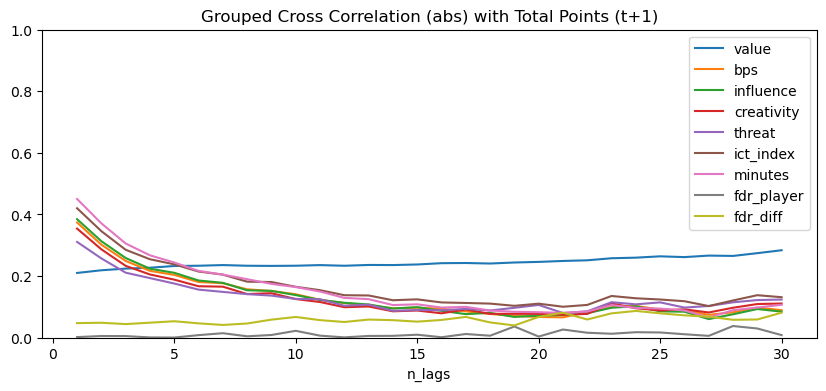

In [15]:
n_lags=30
corr_df = pd.DataFrame(index=list(range(1,n_lags+1)))
for col in REALS:
  corr_df[col] = [crosscorr(data=fpl_data[points_ge25],x_col=col,y_col='total_points', lag=i) for i in range(1,n_lags+1)]

corr_df.abs().plot(title='Grouped Cross Correlation (abs) with Total Points (t+1)',xlabel='n_lags',figsize=(10,4),ylim=(0,1))
plt.show()

Here are the correlations for the static features that are either static, or, we will have future information about

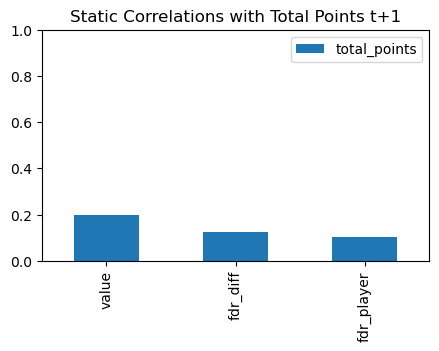

In [16]:
fpl_data.loc[points_ge25,['total_points','value','fdr_player','fdr_diff']].corr('spearman')[TARGET].abs()\
        .drop(TARGET,axis=0)\
            .sort_values(TARGET,ascending=False)\
                .plot.bar(ylim=(0,1),title='Static Correlations with Total Points t+1',figsize=(5,3))
plt.show()

## Feature Importance

While correlations give a quick insight, they do not accommodate categorical features, or, indicate the relevance of features in the presence of other data.

This is something which can be achieved by inspecting modelled feature importances.

For this task, a linear Lasso regression is used which can shrink the covariates to zero. The model is also simple to train with very few hyper parameters and is ideal for a quick analysis.

While we would like to make multiple predictions into the future, for this task, a single-step appraoch is used to keep it simple.

In [17]:
from src.data.feature_processing import gen_grouped_lagged_features

Generate lagged columns for time varying features. This procure is grouped to avoid data leaking between different players/seasons.

In [18]:
#Func to generate lags of features
from src.data.feature_processing import gen_grouped_lagged_features
n_lags = 20

time_varying_unknown_reals_X = gen_grouped_lagged_features(fpl_data.loc[points_ge25,TIME_VARYING_UNKNOWN_REALS+['uid']],group_col='uid',n_lags=n_lags)
TIME_VARYING_UNKNOWN_REALS_TRANSFORMED = time_varying_unknown_reals_X.columns.values.tolist()

time_varying_known_reals_X = gen_grouped_lagged_features(fpl_data.loc[points_ge25,TIME_VARYING_KNOWN_REALS+['uid']],group_col='uid',n_lags=n_lags)
TIME_VARYING_KNOWN_REALS_TRANSFORMED = time_varying_known_reals_X.columns.values.tolist()

time_varying_known_categoricals_X = gen_grouped_lagged_features(fpl_data.loc[points_ge25,TIME_VARYING_KNOWN_CATEGORICALS+['uid']],group_col='uid',n_lags=n_lags).astype('str')
TIME_VARYING_KNOWN_CATEGORICALS_TRANSFORMED = time_varying_known_categoricals_X .columns.values.tolist()

lagged_cols = TIME_VARYING_UNKNOWN_REALS_TRANSFORMED+TIME_VARYING_KNOWN_REALS_TRANSFORMED+TIME_VARYING_KNOWN_CATEGORICALS_TRANSFORMED

print('Example of lagged data:')
time_varying_unknown_reals_X.tail()


Example of lagged data:


,bps_lag1,bps_lag2,bps_lag3,bps_lag4,bps_lag5,bps_lag6,bps_lag7,bps_lag8,bps_lag9,bps_lag10,...,value_lag11,value_lag12,value_lag13,value_lag14,value_lag15,value_lag16,value_lag17,value_lag18,value_lag19,value_lag20
34698,0.0,9.0,22.0,0.0,13.0,10.0,19.0,10.0,0.0,15.0,...,58.0,57.0,56.0,54.0,54.0,54.0,54.0,54.0,54.0,54.0
34699,34.0,18.0,18.0,0.0,10.0,29.0,21.0,0.0,0.0,17.0,...,58.0,60.0,60.0,59.0,59.0,59.0,59.0,59.0,59.0,59.0
34701,30.0,22.0,12.0,25.0,15.0,37.0,18.0,21.0,15.0,15.0,...,48.0,48.0,48.0,48.0,48.0,48.0,49.0,49.0,49.0,49.0
34706,14.0,15.0,12.0,6.0,18.0,21.0,25.0,13.0,12.0,11.0,...,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
34709,16.0,0.0,0.0,10.0,13.0,10.0,10.0,10.0,31.0,-2.0,...,79.0,79.0,79.0,79.0,79.0,79.0,79.0,78.0,78.0,79.0


Create X data including past lags AND data that is available at time t

In [19]:
#Static and future X i.e. where we have access to the feature at timestep t
X = fpl_data.loc[points_ge25,TIME_VARYING_KNOWN_REALS+TIME_VARYING_KNOWN_CATEGORICALS+STATIC_REALS+STATIC_CATEGORICALS]

#Concat with  lagged inputs
X = pd.concat([X,time_varying_unknown_reals_X,time_varying_known_reals_X,time_varying_known_categoricals_X ],axis=1)

#y val
y= fpl_data.loc[points_ge25,TARGET]

Build the pre-processing pipe using the sklearn ColumnTransformer functionality

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant',fill_value=-100)),
       ('scaler',  StandardScaler())])

categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
       ('one_hot', OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, TIME_VARYING_KNOWN_REALS+STATIC_REALS+TIME_VARYING_UNKNOWN_REALS_TRANSFORMED+TIME_VARYING_KNOWN_REALS_TRANSFORMED),
        ('cats', categorical_transformer, STATIC_CATEGORICALS+TIME_VARYING_KNOWN_CATEGORICALS+TIME_VARYING_KNOWN_CATEGORICALS_TRANSFORMED)])


Create model pipe including the Lasso regressor and fit to our data using 5 folds

In [23]:
from sklearn.linear_model import LassoCV
from src.configs.model_config import RANDOM_SEED
#Define and fit the pipe
model_pipe = Pipeline(steps=[('preprocessor',preprocessor),('regr',LassoCV(cv=5, max_iter=10000,random_state=RANDOM_SEED))]).fit(X,y.values.ravel())

As the one-hot encoding expandas the data (i.e. was_home = was_home_TRUE, was_home_FALSE...) we need to extract the new features names...

In [ ]:
reals_feature_names = TIME_VARYING_KNOWN_REALS+STATIC_REALS+TIME_VARYING_UNKNOWN_REALS_TRANSFORMED+TIME_VARYING_KNOWN_REALS_TRANSFORMED
cats_feature_names = model_pipe['preprocessor'].transformers_[1][1]\
    ['one_hot'].get_feature_names(STATIC_CATEGORICALS+TIME_VARYING_KNOWN_CATEGORICALS+TIME_VARYING_KNOWN_CATEGORICALS_TRANSFORMED).tolist()
    
feature_names = reals_feature_names+cats_feature_names
print('Example: \n', feature_names[-10:])

Example: 
 ['was_home_l17_nan', 'was_home_l18_False', 'was_home_l18_True', 'was_home_l18_nan', 'was_home_l19_False', 'was_home_l19_True', 'was_home_l19_nan', 'was_home_l20_False', 'was_home_l20_True', 'was_home_l20_nan']


We can then create a new Pandas series that includes the coefficients/importances with the new feature names as the index

In [ ]:
importances = pd.Series(model_pipe['regr'].coef_,index=feature_names ).abs().sort_values(ascending=False).rename("Importance")
importances.head()

ict_index_l1    2.677022
value_l1        1.044895
minutes_l1      0.659084
position_GKP    0.654841
threat_l1       0.559408
Name: Importance, dtype: float64

Finally, we can review the output of the importances.This analysis then serves two purposes
1. It tells us what features are most useful for predicting player level GW points
2. It indicates how many games in the past we might need to consider for the analysis

In [ ]:
#custom plotting function
from src.plotting.eda import plot_static_and_future_importances,plot_time_varying_importances

Firstly, starting with the time varying features, we can see unlike the correlation analysis,  the coefficients/importances tail off more rapidly and vary according to the feature.

For the TIME_VARYING_UNKNOWN features we see that the ICT_index is significantly more important followed by the past value information.

Across most variables, we see that the importance is almsot entirely diminished up to 6 lags, but there is some residual importance remaining up to ~16 lags.

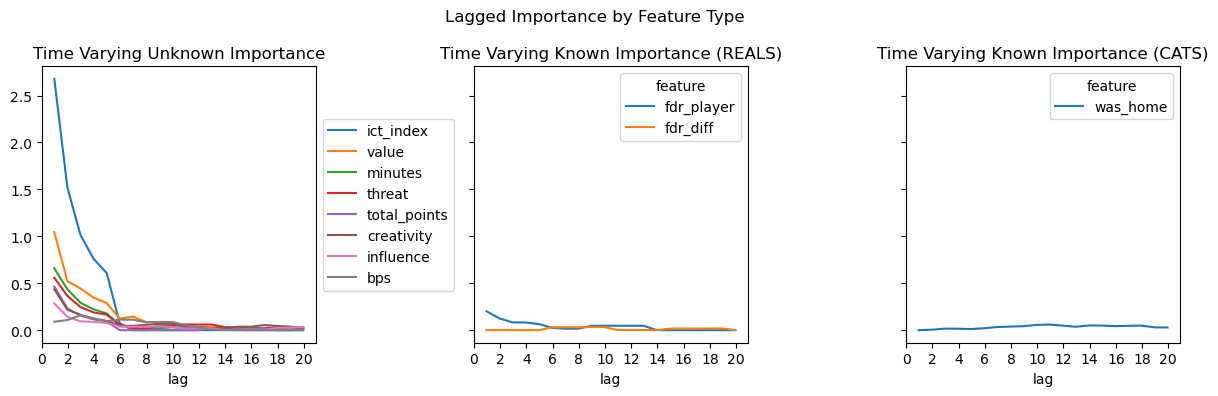

In [ ]:
plot_time_varying_importances(importances,TIME_VARYING_UNKNOWN_REALS_TRANSFORMED,TIME_VARYING_KNOWN_REALS_TRANSFORMED,TIME_VARYING_KNOWN_CATEGORICALS_TRANSFORMED)

For the static and future features (which we have access to in future steps) we see that overall the importances tend to be lower than the time varying features.

Still, all features remain somewhat useful as they do not have coefficients set to zero.

The player position in particular is important here, and specifically the GKP position. This is likely due to the fact that outfield positions are more heavily dictated by the time varying unknown features e.g. ict_index, value etc.

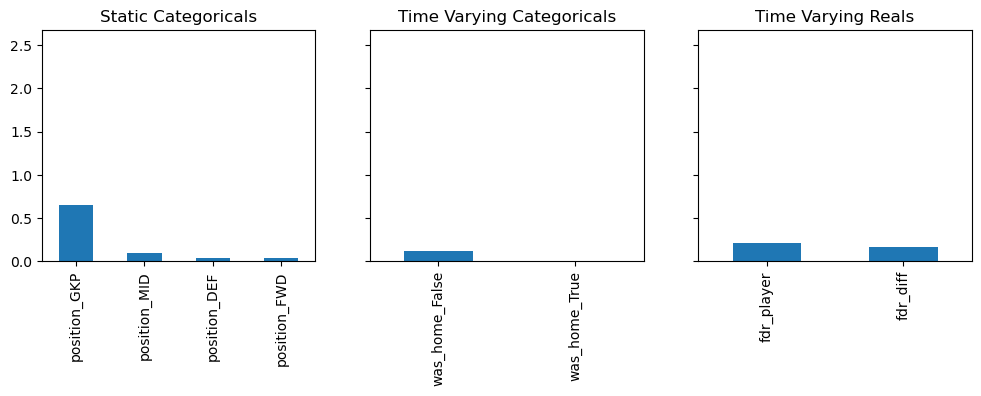

In [ ]:
plot_static_and_future_importances(importances,STATIC_CATEGORICALS,TIME_VARYING_KNOWN_CATEGORICALS,TIME_VARYING_KNOWN_REALS)